In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
from collections import Counter

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

src_root = Path().resolve().parents[0]
sys.path.insert(0, str(src_root)) 
from gates import hadamard_gate

This notebook is now broken because it is now in CS5960PHYS/notebooks and not in CS5960PHYS/src/notebooks.

## 4-qubit Grover with Qiskit

Measurement results: {'0010': 2, '0000': 4, '1110': 5, '1001': 7, '1010': 6, '1000': 4, '0100': 6, '1100': 5, '0101': 5, '0110': 4, '0011': 11, '0001': 6, '0111': 7, '1101': 4, '1111': 5, '1011': 919}


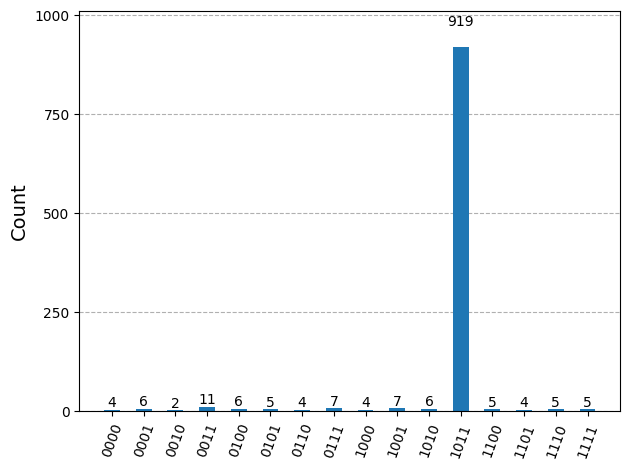

In [2]:
# modified from source: https://medium.com/@srilaa/grovers-algorithm-in-qiskit-89db72c2a06a

num_qubits = 4
desired_item = '1011'[::-1]  # last part just flips it so output isn't reversed
num_iterations = 2

oracle = QuantumCircuit(num_qubits)

# Step 1: Flip qubits where the target has '0'
for i, bit in enumerate(desired_item):
    if bit == '0':
        oracle.x(i)

# Step 2: Multi-controlled Z (mark the target state)
# Use H + MCX + H trick to implement multi-controlled Z
oracle.h(num_qubits-1)
oracle.mcx(list(range(num_qubits-1)), num_qubits-1)
oracle.h(num_qubits-1)

# Step 3: Undo the X gates
for i, bit in enumerate(desired_item):
    if bit == '0':
        oracle.x(i)

# Convert oracle to a gate
oracle_gate = oracle.to_gate()
oracle_gate.name = "Oracle"

# --- BUILD DIFFUSION OPERATOR ---
diffusion = QuantumCircuit(num_qubits)

# Step 1: Apply H to all qubits
diffusion.h(range(num_qubits))

# Step 2: Apply X to all qubits
diffusion.x(range(num_qubits))

# Step 3: Multi-controlled Z
diffusion.h(num_qubits-1)
diffusion.mcx(list(range(num_qubits-1)), num_qubits-1)
diffusion.h(num_qubits-1)

# Step 4: Apply X and H again
diffusion.x(range(num_qubits))
diffusion.h(range(num_qubits))

# Convert diffusion to a gate
diffusion_gate = diffusion.to_gate()
diffusion_gate.name = "Diffusion"

# --- BUILD FULL GROVER CIRCUIT ---
grover_circuit = QuantumCircuit(num_qubits, num_qubits)

# Step 1: Initialize with Hadamards
grover_circuit.h(range(num_qubits))

# Step 2: Apply Grover iterations
for _ in range(num_iterations):
    grover_circuit.append(oracle_gate, range(num_qubits))
    grover_circuit.append(diffusion_gate, range(num_qubits))

# Step 3: Measure
grover_circuit.measure(range(num_qubits), range(num_qubits))

# --- SIMULATE ---
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(transpile(grover_circuit, simulator), shots=1000)
result = job.result()
counts = result.get_counts(grover_circuit)

# --- OUTPUT ---
print("Measurement results:", counts)
plot_histogram(counts)


## 4-qubit Grover with NumPy

In [3]:
num_qubits = 4
N = 2 ** num_qubits
desired_item = '0000'
num_iterations = 2
shots = 1000

state = np.zeros(N, dtype=complex)
state[0] = 1.0

H = hadamard_gate()
# H = (1 / np.sqrt(2)) * np.array([[1, 1],
#                                  [1, -1]])

H_n = H
for _ in range(num_qubits - 1):
    H_n = np.kron(H_n, H)

state = H_n @ state

# phase flip only the target state
oracle = np.eye(N, dtype=complex)
target_index = int(desired_item, 2)
oracle[target_index, target_index] = -1

# D = 2|s><s| - I
s = np.ones(N) / np.sqrt(N)
diffusion = 2 * np.outer(s, s) - np.eye(N)

for _ in range(num_iterations):
    state = oracle @ state
    state = diffusion @ state

# simulate running circuit
probabilities = np.abs(state) ** 2
samples = np.random.choice(N, size=shots, p=probabilities)
counts = Counter(format(s, f'0{num_qubits}b') for s in samples)


Measurement results: {'0000': 905, '1001': 9, '0111': 14, '0101': 4, '1011': 10, '1101': 9, '1000': 9, '1110': 5, '1100': 6, '0011': 1, '0110': 6, '0001': 5, '1010': 2, '1111': 8, '0100': 5, '0010': 2}


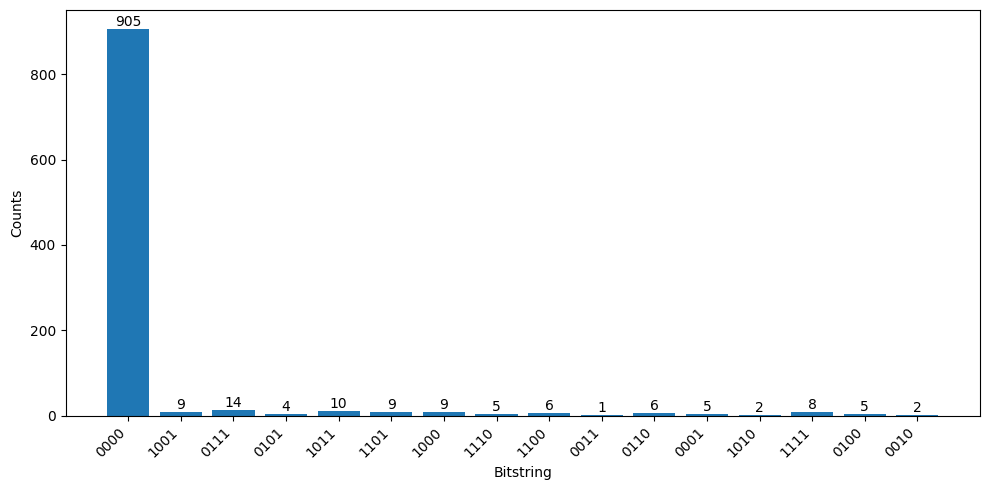

In [4]:
# plotting and output
print("Measurement results:", dict(counts))

plt.figure(figsize=(10, 5))
bars = plt.bar(counts.keys(), counts.values())
plt.xlabel("Bitstring")
plt.ylabel("Counts")
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


### Introducing error

In [48]:
# defining paramters, gates and helper functions
num_qubits = 4
N = 2 ** num_qubits
desired_item = '1101'
num_iterations = int(np.floor((np.pi/4)*np.sqrt(N)))
shots = 1000

p_bitflip = 0.01
p_phaseflip = 0.01

bitflip_occurred = False
phaseflip_occurred = False

# TODO: import these from gates.py instead to reduce clutter
I = np.eye(2)
X = np.array([[0, 1],
              [1, 0]])
Z = np.array([[1,  0],
              [0, -1]])

H = (1 / np.sqrt(2)) * np.array([[1,  1],
                                 [1, -1]])

# TODO: move these to utils instead to reduce clutter
def lift_gate(gate: np.array, qubit: int, num_qubits: int = num_qubits) -> np.array:
    """Takes an operator that is defined for one qubit and embeds it into the full multi-qubit Hilbert space.
    The operator still acts on one qubit while leaving others unchanged.

    Args:
        gate (np.array): Single-qubit gate to lift.
        qubit (int): Which qubit in the system to apply the gate to, by index
        num_qubits (int, optional): _description_. Defaults to num_qubits.

    Returns:
        np.array: NxN multi-qubit operator resulting in same state as 
    """
    ops = []
    for i in range(num_qubits):
        ops.append(gate if i == qubit else I)
    U = ops[0]
    for op in ops[1:]:
        U = np.kron(U, op)
    return U

def apply_noise(state: np.array) -> np.array:
    """Apply noise at each tick.

    Args:
        state (np.array): array describing current state

    Returns:
        np.array: current state with stachastic noise applied
    """
    for q in range(num_qubits):
        if np.random.random() < p_bitflip:
            global bitflip_occurred
            bitflip_occurred = True
            state = lift_gate(X, q, num_qubits) @ state
        if np.random.random() < p_phaseflip:
            global phaseflip_occurred
            phaseflip_occurred = True
            state = lift_gate(Z, q, num_qubits) @ state
    return state


### Defining and running circuit (with ticks to simulate time passing)

In [61]:

# INITIAL STATE
state = np.zeros(N, dtype=complex)
state[0] = 1.0

tick = 0

def advance_tick(state, label=""):
    global tick
    tick += 1
    state = apply_noise(state)
    return state

# HADAMARD ON ALL QUBITS
H_n = H
for _ in range(num_qubits - 1):
    H_n = np.kron(H_n, H)

state = H_n @ state
state = advance_tick(state, "Initial Hadamards")

# ORACLE
oracle = np.eye(N, dtype=complex)
target_index = int(desired_item, 2)
oracle[target_index, target_index] = -1

# DIFFUSION
s = np.ones(N) / np.sqrt(N)
diffusion = 2 * np.outer(s, s) - np.eye(N)

# GROVER LOOP WITH TICKS
for iteration in range(num_iterations):
    state = oracle @ state
    state = advance_tick(state, f"Oracle iteration {iteration}")

    state = advance_tick(state, "Idle")

    state = diffusion @ state
    state = advance_tick(state, f"Diffusion iteration {iteration}")

    state = advance_tick(state, "Idle")

# MEASUREMENT
probabilities = np.abs(state) ** 2
samples = np.random.choice(N, size=shots, p=probabilities)
counts = Counter(format(s, f'0{num_qubits}b') for s in samples)


Total ticks elapsed: 13
Measurement results: {'1001': 122, '0110': 21, '0100': 104, '1101': 103, '0010': 25, '0101': 106, '1000': 120, '1011': 27, '0001': 127, '0000': 117, '1110': 27, '1010': 28, '0111': 32, '0011': 23, '1111': 18}
Num iterations: 3
Bit-flip occurred: True
Phase-flip occurred: True


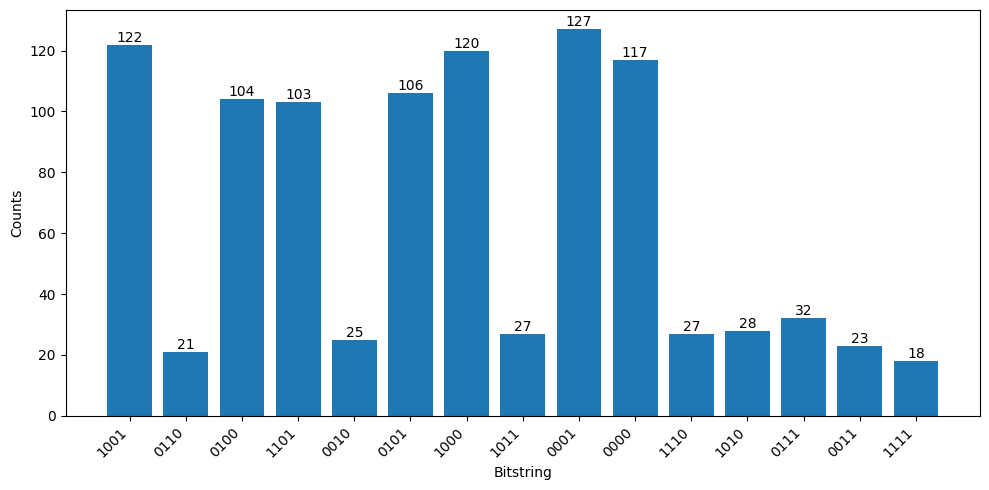

In [62]:
# plotting and output
print(f"Total ticks elapsed: {tick}")
print("Measurement results:", dict(counts))
print("Num iterations:", num_iterations)

print("Bit-flip occurred:", bitflip_occurred)
print("Phase-flip occurred:", phaseflip_occurred)

plt.figure(figsize=(10, 5))
bars = plt.bar(counts.keys(), counts.values())
plt.xlabel("Bitstring")
plt.ylabel("Counts")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

There are many possible minor improvements I can make to make the error model more realistic, such as:
- Be more specific about the number of ticks that pass during and between operations.
- Increase p of error as number of ticks increases, to simulate the machine heating up and the qubits becoming more unstable.

According to https://scipost.org/SciPostPhysLectNotes.49/pdf, "it takes a minimum of thirteen physical qubits to implement a single surface code logical qubit (even with zero physical qubit error rate)." 

"A distance d surface code requires a lattice of (2d – 1) × (2d – 1) physical qubits in order to encode a single logical qubit. As apparent from the formula, a surface code with a distance of three—the smallest possible code—requires 25 physical qubits to encode a logical qubit.
National Academies of Sciences, Engineering, and Medicine. 2019. Quantum Computing: Progress and Prospects. Washington, DC: The National Academies Press. https://doi.org/10.17226/5327."

### Note to self:
I will not be able to run any kind of circuit that requires simualting upwards of 10 qubits PER logical qubit, even if my whole circuit runs with n=2.

Potential solution 1:
- Use a different, shittier type of error correcting code

Drawbacks of that solution:
- Further removed from what is actually going on in the field, and the level of abstraction away from any real application is only increased. As a reminder, I have already decreased key length down to 2 instead of 256, and I'm kind of not even using AES anymore to encrypt, as my function f is a true oracle and somehow just knows the answer.

Find out:
1. What is the max number of qubits I can actually work with? (LIQUi|> suggested 30 was possible) Is there a simple way for me to get more, like using some computing power that I get from the university somehow on a remote machine?
2. Would I truly need as many as 13 or 17 qubits for the surface code?
3. Is that not also another arbitrary abstraction I'm making here? In reality I would need thousands, so what's the difference if I use a code with d=2 or d=3 when both are so far off reality?

### Does a 2x2 surface code even make definitional sense?
Apparently yes, but it can't correct anything so it's basically useless. Assuming the ChatGPT code I used was as optimized as possible (huge assumption and already disproven), I need to figure out another strategy.
1. Gain more intel on how close to doable this is, counting operations or memory space or something.
2. Try on a different, beefier computer?
3. Try with a smaller, less realistic code, like the 5- or 7-qubit code.

If none of these work, which you honestly should probably know by Friday, then you need to think about taking the project in a different direction.
1. Further exploration of the code base Anton and Brage made, perhaps expanded to logical operators to show how to do a few kinds of operations?
2. Comparison of using different gate sets (although I am frankly more excited by the error correcting codes part).

### According to ChatGPT:

Include some of this next part in thesis:

6. Important subtlety: stabilizer simulation does NOT save you
You might think:
“But surface codes are stabilizer codes — can’t I use stabilizer simulation?”
Unfortunately:
Grover’s oracle is non-Clifford
The diffusion operator is non-Clifford
Any meaningful Grover circuit breaks stabilizer-only simulation
So you fall back to full state vectors unless you heavily approximate or restrict the oracle.
7. What people actually do instead
For exactly this reason, researchers usually:
Simulate Grover at the logical level (no encoding)
Simulate the surface code separately
Syndrome extraction
Logical error rates
Combine results analytically
“Assuming logical error rate 
p
L
p 
L
​	
 , Grover succeeds with probability …”
LIQUi|> was sometimes used to partially bridge this gap, but even it did not scale far.



New idea: Use Panqec to compare specific gates or operators across different codes, maybe focus on one step in the procedure like maybe the T gate? And compare that to how the T gate looks when applied to BB code/tile code etc. Or maybe even look at just the Paulis and Hadamard gates or something and compare how the structure might look in a few different kinds of code. See if you can find a pattern?

But, most importantly, start fresh on Thursday and look into these new paths, and then you can discuss them with Joakim on Friday. You'll only have a half day that day anyway and you can do music stuff :)